In [1]:
# Βιβλιοθήκες
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files
from urllib.parse import urlparse

In [2]:
!pip install tensorflow
import tensorflow

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential, Model
from time import time
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D, Input, Concatenate
from tensorflow.keras.layers import BatchNormalization


In [4]:
# Upload το CSV αρχείο
uploaded = files.upload()

Saving my_new_data.csv to my_new_data.csv


In [5]:
# Διαβάζουμε το CSV αρχείο μέσω του Pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded['my_new_data.csv']))

# Παρουσίαση πρώτων 5 γραμμών
df.head()

,url,type,Category,url_len,num_subdomains,num_dots,digits,special_chars,letters,Https,Shortening_Service,having_ip
0,br-icloud.com.br,phishing,2,16,0,2,0,3,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,2,1,5,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,2,1,5,25,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,2,7,17,60,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,2,22,14,199,0,0,0


In [6]:
# τιμές της στήλης type
flist = df['type'].value_counts()
flist

,count
type,
benign,428080
defacement,95308
phishing,94086
malware,23645


**Κανονικοποίηση** *(πριν το διαχωρισμό Train/Test)*

In [9]:
# One-Hot Encoding των Ετικετών
y = to_categorical(df['Category'])

# Χαρακτηριστικό - ολόκληρο URL
# Παίρνουμε τη στήλη με τα URLs ως λίστα
urls = df['url'].astype(str).tolist()

# ψάχνουμε να βρούμε το καλύτερο μήκος για είσοδο ακολουθίας - max_len
# Υπολογισμός του μήκους κάθε URL
length = [len(url) for url in urls]

# Στατιστικά:
percentiles ={
    "max": max(length),
    "mean": np.mean(length),
    #Το 90%, 95%, 99% των URLs έχουν μήκος <= n χαρακτήρες.
    "90th": np.percentile(length, 90),
    "95th": np.percentile(length, 95),
    "99th": np.percentile(length,99)
}

percentiles

{'max': 2175,
 'mean': np.float64(58.98939042517848),
 '90th': np.float64(106.0),
 '95th': np.float64(133.0),
 '99th': np.float64(234.0)}

In [10]:
# Χρήση tokenizer χαρακτήρων (char-level)
char_tokenizer = Tokenizer(char_level=True, lower=False)
char_tokenizer.fit_on_texts(urls)

# Πλήθος μοναδικών χαρακτήρων
# Μέγεθος λεξικού (vocab_size)
vocab_size = len(char_tokenizer.word_index) + 1 # προσθέτουμε 1 για padding
# πίνακες με τα κωδικοποιημένα χαρακτηριστικά
url_sequences = char_tokenizer.texts_to_sequences(urls)
# μέγιστο μήκος
max_len = 230
# Padding ακολουθιών - ίδιο μήκος όλες οι ακολουθίες
# padding='post' - προσθήκη padding στο τέλος κάθε ακολουθίας
# truncating ='post' - περιορίζει το μήκος της ακολουθίας αφαιρώντας στοιχεία από το τέλος
padded_urls = pad_sequences(url_sequences, maxlen=max_len, padding='post', truncating='post')

In [11]:
vocab_size

334

In [16]:
#πρώτο στοιχείο urls[0]
#url_sequences[0]
#type(padded_urls)

# Το σύνολο των μοναδικών tokens (χαρακτήρων) που ενφανίζονται στα δεδομένα
print(char_tokenizer.word_index)

{'e': 1, 'o': 2, 't': 3, 'a': 4, '/': 5, 'i': 6, 'n': 7, 'c': 8, 's': 9, 'r': 10, 'm': 11, '.': 12, 'l': 13, 'p': 14, 'd': 15, '-': 16, 'h': 17, 'u': 18, 'g': 19, 'b': 20, '1': 21, '0': 22, 'f': 23, '2': 24, 'y': 25, 'w': 26, '=': 27, 'k': 28, '3': 29, '8': 30, 'v': 31, '5': 32, '4': 33, '9': 34, '_': 35, '%': 36, '6': 37, '&': 38, '7': 39, ':': 40, 'x': 41, '?': 42, 'j': 43, 'D': 44, 'z': 45, 'A': 46, 'B': 47, 'I': 48, 'C': 49, 'E': 50, 'S': 51, 'F': 52, 'M': 53, 'q': 54, 'L': 55, 'P': 56, 'R': 57, 'T': 58, 'N': 59, 'W': 60, '+': 61, 'G': 62, 'H': 63, 'O': 64, 'Z': 65, 'J': 66, 'Y': 67, 'V': 68, 'U': 69, 'Q': 70, 'X': 71, ';': 72, 'K': 73, '\\': 74, "'": 75, '~': 76, '(': 77, ')': 78, 'ะ': 79, ',': 80, '[': 81, ']': 82, '@': 83, '!': 84, 'พ': 85, '#': 86, 'ต': 87, '|': 88, 'ฝ': 89, ' ': 90, 'ธ': 91, 'ฐ': 92, 'ร': 93, 'ผ': 94, '*': 95, 'é': 96, 'บ': 97, 'ฒ': 98, 'Ã': 99, 'Â': 100, '}': 101, '{': 102, '\x82': 103, '\x83': 104, 'ฑ': 105, '$': 106, 'ณ': 107, 'ฟ': 108, 'ป': 109, 'ฮ': 110, 

In [17]:
# Αριθμητικά Χαρακτηριστικά
# Ορισμός 2 κατηγοριών χαρακτηριστικών
numeric_features = ['url_len', 'num_subdomains', 'num_dots', 'digits', 'special_chars', 'letters']
binary_features = ['Https', 'Shortening_Service', 'having_ip']
features = numeric_features + binary_features


In [19]:
# κανονικοποίηση αριθμητικών
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numeric_features])
# λογικά χαρακτηριστικά παραμένουν ίδια
X_bin = df[binary_features].values
# συνένωση κατά στήλη - γραμμή προς γραμμή, άρα δεν αλλάζει η αντιστοίχιση
X_final = np.hstack((X_num, X_bin))

**Έλεγχος Αντιστοιχίας**

In [20]:
# αρχικά αριθμητικά
print(df.iloc[0][numeric_features].values)
#scaled αριθμητικά
print(X_num[0])
# δυαδικά
print(X_bin[0])
# τελική μορφή
print(X_final[0])

[np.int64(16) np.int64(0) np.int64(2) np.int64(0) np.int64(3) np.int64(13)]
[-0.96249376 -0.32234222 -0.00356299 -0.46177625 -0.76313968 -1.00202921]
[0 0 0]
[-0.96249376 -0.32234222 -0.00356299 -0.46177625 -0.76313968 -1.00202921
  0.          0.          0.        ]


In [27]:
# μετατροπή σε DataFrame για προβολή όλων των χαρακτηριστικών με ετικέτες
X_final_df = pd.DataFrame(X_final, columns=features)
X_final_df

,url_len,num_subdomains,num_dots,digits,special_chars,letters,Https,Shortening_Service,having_ip
0,-0.962494,-0.322342,-0.003563,-0.461776,-0.763140,-1.002029,0.0,0.0,0.0
1,-0.537101,-0.322342,-0.003563,-0.375789,-0.510338,-0.494655,0.0,0.0,0.0
2,-0.626657,-0.322342,-0.003563,-0.375789,-0.510338,-0.621499,0.0,0.0,0.0
3,0.559965,-0.322342,-0.003563,0.140134,1.006471,0.488383,0.0,0.0,0.0
4,3.940719,-0.322342,-0.003563,1.429941,0.627269,4.896196,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
641114,-0.447544,0.709481,0.710503,0.570069,-0.383937,-0.748342,0.0,0.0,0.0
641115,-0.335599,0.709481,-0.003563,0.140134,-0.131136,-0.494655,0.0,1.0,0.0
641116,-0.469934,-0.322342,-0.717629,-0.203815,-0.510338,-0.462944,0.0,1.0,0.0
641117,-0.313210,0.709481,-0.003563,-0.461776,-0.004735,-0.272679,0.0,0.0,0.0


**Εκπαίδευση**

In [42]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    start_time= time()

    # Εκπαίδευση του μοντέλου
    model.fit(X_train, y_train, epochs=7, batch_size=128, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    training_time = time() - start_time

    # Αξιολόγηση μοντέλου στο test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Προβλέψεις - επιστρέφει πιθανότητες (softmax)
    y_pred_prob = model.predict(X_test)
    # Κατηγορία με τη μεγαλύτερη πιθανότητα
    y_pred = np.argmax(y_pred_prob, axis=1)
    # Πραγματική κατηγορία από one-hot y_test
    y_true = np.argmax(y_test, axis=1)

    # Υπολογισμός μετρικών
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall= recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1= f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Εκτύπωση λεπτομερούς αναφοράς
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Πίνακας - Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    return model_name, round(accuracy, 4), round(precision, 4), round(recall, 4) , round(f1, 4), round(training_time, 2)

Epoch 1/7


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4007/4007 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7255 - loss: 0.7084 - val_accuracy: 0.8122 - val_loss: 0.5107
Epoch 2/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8023 - loss: 0.5340 - val_accuracy: 0.8173 - val_loss: 0.4834
Epoch 3/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8104 - loss: 0.5100 - val_accuracy: 0.8209 - val_loss: 0.4741
Epoch 4/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8136 - loss: 0.5016 - val_accuracy: 0.8217 - val_loss: 0.4718
Epoch 5/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8145 - loss: 0.4970 - val_accuracy: 0.8221 - val_loss: 0.4710
Epoch 6/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8162 - loss: 0.4938 - val_accuracy: 0.8232 - val_loss: 0.4662
Epoch 7/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8164 - loss: 0.4915 - val_accuracy: 0.8240 - val_loss: 0.4659
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Classification Report for MLP:

              precision 

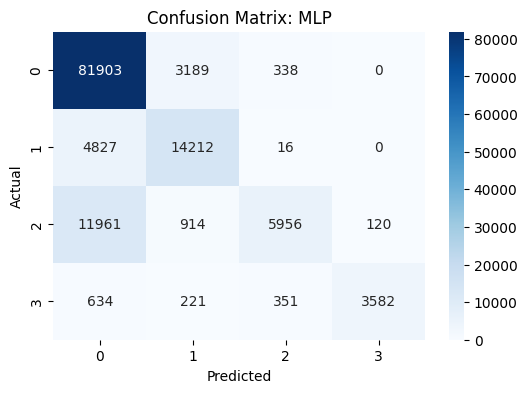

  Model  Accuracy  Precision  Recall  F1-Score  Training Time
0   MLP     0.824     0.8316   0.824    0.8033          128.1


In [43]:
# Εκπαίδευση με αριθμητικά χαρακτηριστικά
X_train_num, X_test_num, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# MLP Model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    BatchNormalization(), # Κανονικοποίηση για σταθερότητα
    Dropout(0.3),   # Για regularization, απενεργοποιώντας το 30% των νευρώνων
    Dense(64, activation='relu'),
    Dropout(0.3),   # για αποφυγή overfitting
    Dense(4, activation='softmax') # 4 κατηγορίες εξόδου
])

results = []
# Σύνταξη του μοντέλου
mlp_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Εκπαίδευση και Αξιολόγηση
result = train_and_evaluate(mlp_model, X_train_num, X_test_num, y_train, y_test, 'MLP')
# Προσθήκη στη τελική λίστα αποτελεσμάτων
results.append(result)

# Παρουσίαση αποτελεσμάτων
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'])
print(results_df)

In [44]:
mlp_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,414 (118.81 KB)

 Trainable params: 10,052 (39.27 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 20,106 (78.54 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2241s 558ms/step - accuracy: 0.8897 - loss: 0.3356 - val_accuracy: 0.9471 - val_loss: 0.1415
Epoch 2/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 1858s 463ms/step - accuracy: 0.9458 - loss: 0.1498 - val_accuracy: 0.9559 - val_loss: 0.1175
Epoch 3/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 1846s 461ms/step - accuracy: 0.9538 - loss: 0.1260 - val_accuracy: 0.9567 - val_loss: 0.1121
Epoch 4/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 1779s 444ms/step - accuracy: 0.9590 - loss: 0.1115 - val_accuracy: 0.9612 - val_loss: 0.1040
Epoch 5/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 1726s 431ms/step - accuracy: 0.9621 - loss: 0.1023 - val_accuracy: 0.9633 - val_loss: 0.0983
Epoch 6/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 1856s 454ms/step - accuracy: 0.9647 - loss: 0.0948 - val_accuracy: 0.9629 - val_loss: 0.1017
Epoch 7/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 1770s 442ms/step - accuracy: 0.9664 - loss: 0.0898 - val_accuracy: 0.9637 - val_loss: 0.0978
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 105s 26ms/step

Classification 

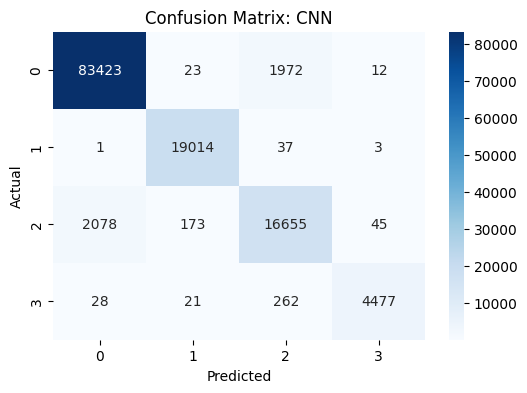

  Model  Accuracy  Precision  Recall  F1-Score  Training Time
0   MLP    0.8240     0.8316  0.8240    0.8033         128.10
1   CNN    0.9637     0.9637  0.9637    0.9637       13076.83


In [48]:
# Εκπαίδευση με URL χαρακτηριστικό
X_train_url, X_test_url, y_train, y_test = train_test_split(padded_urls, y, test_size=0.2, random_state=42)

# CNN Model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Προσθήκη αποτελεσμάτων στη τελική λίστα
results.append(train_and_evaluate(cnn_model, X_train_url, X_test_url, y_train, y_test, 'CNN'))

# Παρουσίαση Αποτελεσμάτων
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'])
print(results_df)

Epoch 1/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 972s 241ms/step - accuracy: 0.8780 - loss: 0.3408 - val_accuracy: 0.9457 - val_loss: 0.1474
Epoch 2/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 971s 242ms/step - accuracy: 0.9357 - loss: 0.1772 - val_accuracy: 0.9490 - val_loss: 0.1348
Epoch 3/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 995s 248ms/step - accuracy: 0.9411 - loss: 0.1602 - val_accuracy: 0.9519 - val_loss: 0.1285
Epoch 4/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 966s 241ms/step - accuracy: 0.9443 - loss: 0.1509 - val_accuracy: 0.9543 - val_loss: 0.1198
Epoch 5/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 989s 247ms/step - accuracy: 0.9463 - loss: 0.1457 - val_accuracy: 0.9559 - val_loss: 0.1172
Epoch 6/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 991s 247ms/step - accuracy: 0.9480 - loss: 0.1407 - val_accuracy: 0.9558 - val_loss: 0.1155
Epoch 7/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 988s 247ms/step - accuracy: 0.9484 - loss: 0.1382 - val_accuracy: 0.9576 - val_loss: 0.1135
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 69s 17ms/step

Classification Report f

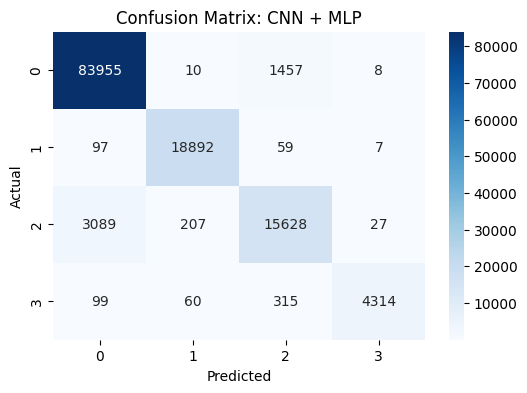

       Model  Accuracy  Precision  Recall  F1-Score  Training Time
0        MLP    0.8240     0.8316  0.8240    0.8033         128.10
1        CNN    0.9637     0.9637  0.9637    0.9637       13076.83
2  CNN + MLP    0.9576     0.9569  0.9576    0.9569        6874.00


In [50]:
# Hybrid CNN + MLP

# Εκπαίδευση με αριθμητικά χαρακτηριστικά και ολόκληρο url
X_train_url, X_test_url, X_train_num, X_test_num, y_train, y_test = train_test_split(padded_urls, X_final, y, test_size=0.2, random_state=42)

# Είσοδος για το URL (σειρά χαρακτήρων -> embedding -> CNN)
input_url = Input(shape=(max_len,),)
# Ενσωμάτωση χαρακτήρων (Emmbedding layer για URLs)
embedding = Embedding(input_dim=vocab_size, output_dim=128)(input_url)
# Convolutional layer για εξαγωγή τοπικών χαρακτηριστικών
cnn_layer = Conv1D(128, 3, activation='relu', padding='same')(embedding)
cnn_layer = GlobalMaxPooling1D()(cnn_layer)

# Κανονικοποίηση και Dropout
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)

# Είσοδος για τα αριθμητικά χαρακτηριστικά (MLP μέρος)
input_num = Input(shape=(len(features),))
mlp_layer = Dense(128, activation='relu')(input_num)
mlp_layer = BatchNormalization()(mlp_layer)
mlp_layer = Dropout(0.3)(mlp_layer)

# Συνδυασμός των δύο (Concatenation)
merged = Concatenate()([cnn_layer, mlp_layer])

# Πλήρως συνδεδεμένο επίπεδο για μάθηση από τα συνδυασμένα χαρακτηριστικά
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.3)(merged)

# Τελικό επίπεδο εξόδου
output = Dense(4, activation='softmax')(merged)

# Ορισμός μοντέλου
cnn_mlp_model = Model(inputs=[input_url, input_num], outputs=output)
cnn_mlp_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Εκπαίδευση και Αξιολόγηση, προσθήκη στη λίστα αποτελεσμάτων
results.append(train_and_evaluate(cnn_mlp_model, [X_train_url, X_train_num], [X_test_url, X_test_num], y_train, y_test, 'CNN + MLP'))

# Παρουσίαση αποτελεσμάτων
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'])
print(results_df)

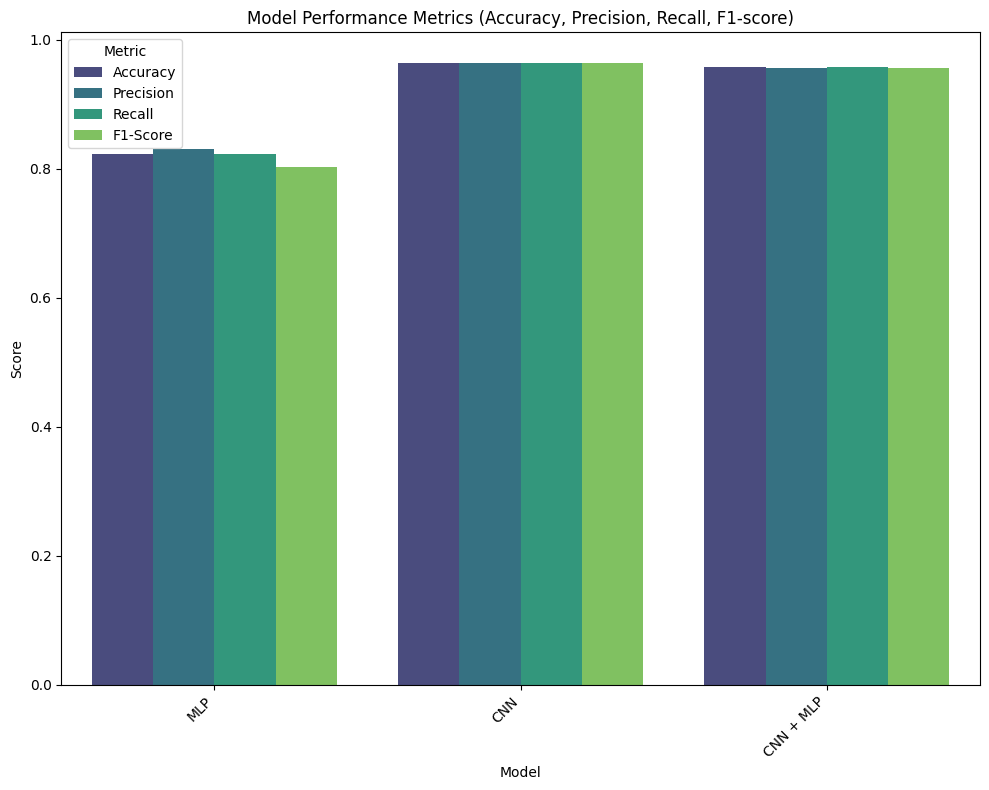

/tmp/ipython-input-3537753896.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time', data=results_df, palette='plasma')


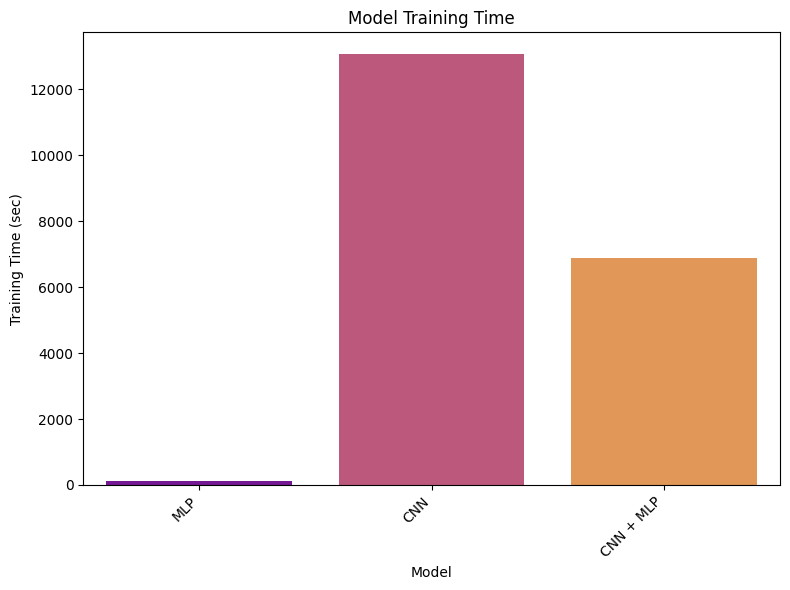

In [52]:
# Διάγραμμα συνολικών αποτελεσμάτων για κάθε μοντέλο (μετρικές και χρόνοι)

# Μετατροπή DataFrame για εύκολη σχεδίαση
results_melt = results_df.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
)

# Διάγραμμα μετρικών
plt.figure(figsize=(10,8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melt, palette='viridis')
plt.title('Model Performance Metrics (Accuracy, Precision, Recall, F1-score)')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Διάγραμμα χρόνου εκπαίδευσης
plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='Training Time', data=results_df, palette='plasma')
plt.title('Model Training Time')
plt.xlabel('Model')
plt.ylabel('Training Time (sec)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()